In [ ]:
import librosa
import torchaudio.transforms
import torch
import torchaudio.functional as F
import time
import numpy as np
a = np.random.random([1, 441000]).astype(np.float32)
resample = torchaudio.transforms.Resample(44100, 16000)

T1 = time.time()
y = librosa.resample(a, orig_sr=44100, target_sr=16000)
T2 = time.time()
print(T2-T1)
T1 = time.time()
y1 = F.resample(
    torch.Tensor(a),
    44100,
    16000,
    lowpass_filter_width=16,
    rolloff=0.95,
    resampling_method="kaiser_window",
    beta=14,
)
T2 = time.time()
print(T2-T1)
T1 = time.time()
y2 = resample(torch.Tensor(a))
T2 = time.time()
print(T2-T1)
print(np.sum(abs(y - y1.numpy())))
print(np.sum(abs(y - y2.numpy())))

In [ ]:
import librosa
a = np.random.random([10, 44100])
b = np.random.random([10, 16000])

a_mfcc = librosa.feature.mfcc(y=a, sr=44100, n_mfcc=13)
b_mfcc = librosa.feature.mfcc(y=b, sr=16000, n_mfcc=13)
print(a_mfcc.shape)
print(b_mfcc.shape)

In [ ]:
import numpy as np
from process_utils import get_file_dict
conf = np.load("npy/conf.npy", allow_pickle=True).item()
key = list(conf.keys())[0]
wav_dict = get_file_dict("MODMA")

concat_data = None
concat_data_ = None
for wav in (wav_dict[key]):
    data, sr = torchaudio.load(wav)
    if concat_data is None:
        concat_data = data
    else:
        concat_data = torch.cat([concat_data, data], dim=1)

for wav in (wav_dict[key]):
    data, sr = librosa.load(wav, sr=None)
    if concat_data_ is None:
        concat_data_ = data
    else:
        concat_data_ = np.hstack([concat_data_, data])
print(np.sum(abs(concat_data.numpy()-concat_data_)))

torchaudio.save()对于librosa是无损保存(当保存为float32类型时)，非float32也只有微小的精度损失

In [ ]:
data = np.random.random([441000])
y1 = librosa.resample(data, orig_sr=44100, target_sr=16000).astype(np.float32)
torchaudio.save("tmp.wav", torch.Tensor(y1).unsqueeze(0), sample_rate=16000)
time.sleep(0.3)
data, sr = librosa.load("tmp.wav", sr=None)
print(np.sum(abs(y1-data)))

In [ ]:
import pandas as pd
from header import *
import seaborn as sns
import matplotlib.pyplot as plt
data = np.load("npy/ABC.npy", allow_pickle=True).item()
x = data['x']
x = x[200]
df = pd.DataFrame(x.T)
plt.figure(figsize=(100,100))
sns.heatmap(df.corr(),annot=True, vmax=1, square=True)
plt.savefig("corr.png")

mean: 
17.2150873669328
std: 
13.548278571986707
max: 
165.3304375
min: 
1.35725
[154, 369, 418, 218, 103, 62, 46, 34, 33, 66]
['(1, 6]', '(6, 11]', '(11, 16]', '(16, 21]', '(21, 26]', '(26, 31]', '(31, 36]', '(36, 41]', '(41, 46]', '(46,]']


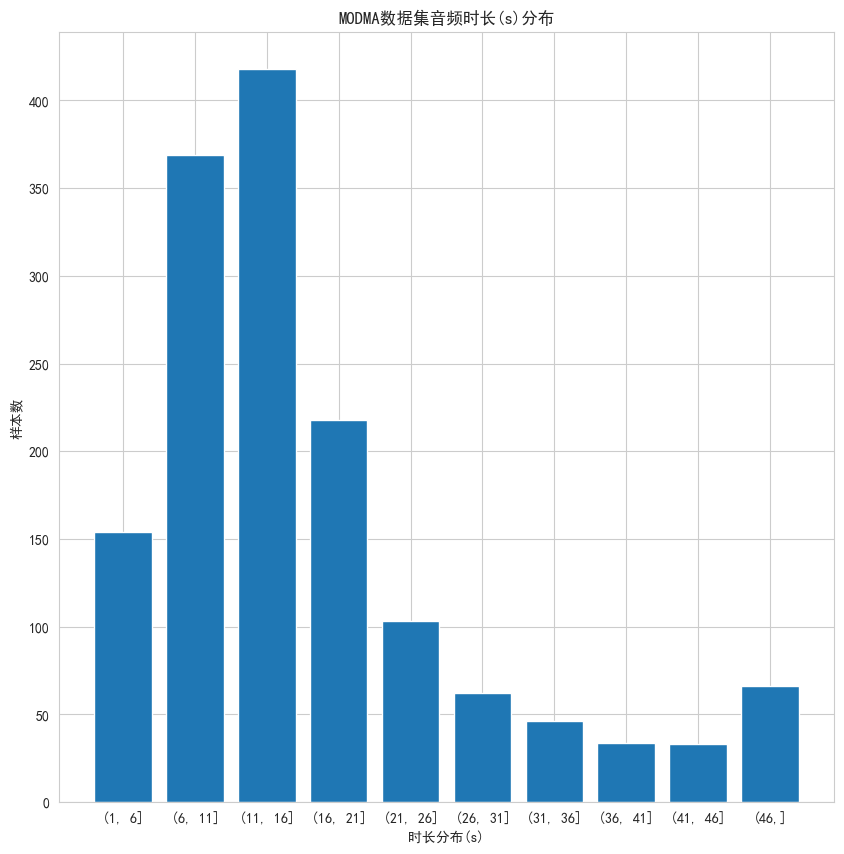

In [11]:
from header import *
from process_utils import data_distribution
distribute = data_distribution("MODMA")
index = np.array(list(distribute.index))
value = distribute.values
no_zero_index = value != 0
index = index[no_zero_index]
value = value[no_zero_index]
index_ = list(index[:9].astype(str))
index_.append("(46,]")
value_ = list(value[:9])
value_.append(np.sum(value[9:]))
print(value_)
print(index_)
plt.figure(figsize=(10,10))
# plt.pie(value_, labels=index_, autopct='%1.1f%%')
plt.bar(range(len(value_)), value_)
plt.title("MODMA数据集音频时长(s)分布")
plt.xticks(range(len(value_)), index_)
# plt.axis('equal')
plt.xlabel("时长分布(s)")
plt.ylabel("样本数")
plt.savefig("dis_hist.svg", dpi=300)

In [ ]:
import pandas as pd
from header import *
import seaborn as sns
data = np.load("data/MODMA_V1_order3.npy", allow_pickle=True).item()
x = data['x']
x = x[1000]
df = pd.DataFrame(x.T)
plt.figure(figsize=(40,40))
sns.heatmap(df.corr(),annot=True, vmax=1, square=True)
plt.savefig("corr_order3.svg")

In [ ]:
# from header import *
import numpy as np
from collections import Counter
data = np.load("data/MODMA_V1_order3.npy", allow_pickle=True).item()
x = data['x']
X = x[0].T
from sklearn.mixture import GaussianMixture as GMM
K = 5
total_labels = []
for k in range(K):
    gmm = GMM(n_components=100).fit(X)
    labels = gmm.predict(X)
    total_labels.append(labels)

# total_mono_labels = []
total_labels2index = []
for k in range(K):
    labels = total_labels[k]
    mono_labels = []
    labels2index = []
    for i in range(1, len(labels)):
        if labels[i] not in mono_labels:
            mono_labels.append(labels[i])
            labels2index.append(i)
    # total_mono_labels.append(mono_labels)
    total_labels2index.append(labels2index)

label2index = np.array(total_labels2index).flatten()
label2index = Counter(label2index)
a1 = sorted(label2index.items(),key = lambda x:x[1],reverse = True)
b = np.array(a1[:100])
index = np.sort(b[:,0])
print(index)
# print(label2index.keys())
# print(label2index.values())
# print(len(label2index.keys()))
# print(list(set(labels)))
# total_labels.append(labels)
# print(len(total_labels))
# print(len(labels))
# print(labels)

In [ ]:
# from process_utils import multiGMM
import numpy as np
path = "data/MODMA_V1_order3.npy"
data = np.load(path, allow_pickle=True).item()
x = data['x']
X = x[3]
# np.count_nonzero(x[3], axis=1)
diff_x = np.diff(X, axis=1)
counts = np.count_nonzero(diff_x, axis=1)
print(max(counts))
# b,s,t,w = np.unique(x[3], return_counts=True,return_index=True,return_inverse=True, axis=1)
# print(b)
# print(s)
# print(t)
# print(w)

In [ ]:
from process_utils import mGMM
import numpy as np
from collections import Counter

path = "data/MODMA_V1_order3.npy"
n_components = 100
data = np.load(path, allow_pickle=True).item()
x = data['x']
X = x[0].T
label2index = mGMM(X=X, K=8, n_components=n_components)
label2index = np.array(label2index).flatten()
label2index_dict = Counter(label2index)
label2index_sorted = sorted(label2index_dict.items(), key=lambda x: x[1], reverse=True)
label2index = np.array(label2index_sorted[:n_components])
index = np.sort(label2index[:, 0])
print(label2index)

In [1]:
from process_utils import data_distribution
data_distribution("datasets/IEMOCAP", step=2)

mean: 
4.589399839092141
std: 
3.1682755471169517
max: 
34.13875
min: 
0.5849375


(0, 2]      1200
(2, 4]      2908
(4, 6]      1477
(6, 8]       854
(8, 10]      448
(10, 12]     238
(12, 14]     121
(14, 16]      75
(16, 18]      26
(18, 20]      15
(20, 22]       5
(22, 24]       5
(24, 26]       2
(26, 28]       2
(28, 30]       2
(30, 32]       1
(32, 34]       0
(34, 36]       1
dtype: int64

In [13]:
import numpy as np
from process_utils import CASIA_code, RAVDESS_code
src_data = np.load("data/CASIA_V2_order3.npy", allow_pickle=True).item()
tgt_data = np.load("data/RAVDESS_V1_order3.npy", allow_pickle=True).item()
x_src = src_data['x']
y_src = src_data['y']
x_tgt = tgt_data['x']
y_tgt = tgt_data['y']
src_label = ['anger', 'happy', 'sad', 'surprise']
tgt_label = ['anger', 'happy', 'sad', 'surprised']
src_id = []
tgt_id = []
src_index = []
tgt_index = []

for l in src_label:
    id = CASIA_code(l)
    for i in range(y_src.shape[0]):
        if np.argmax(y_src[i]) == np.argmax(id):
            src_index.append(i)
for l in tgt_label:
    id = RAVDESS_code(l)
    for i in range(y_tgt.shape[0]):
        if np.argmax(y_tgt[i]) == np.argmax(id):
            tgt_index.append(i)
x_src_ = x_src[src_index]
y_src_ = np.argmax(y_src[src_index])
x_tgt_ = x_tgt[tgt_index]
y_tgt_ = np.argmax(y_tgt[tgt_index])
src_data_ = {"x": x_src_, "y": y_src_}
tgt_data_ = {"x": x_tgt_, "y": y_tgt_}
np.save("data/CASIA_4label.npy", src_data_)
np.save("data/RAVDESS_4label.npy", tgt_data_)

KeyboardInterrupt: 

In [3]:
from process_utils import data_distribution
data_distribution(path="datasets/DAIC", step=1) # 选择6秒作为分界线

mean: 
2.71603138406222
std: 
2.463264220329114
max: 
45.08
min: 
0.01


(0, 1]      9124
(1, 2]      7358
(2, 3]      5119
(3, 4]      3449
(4, 5]      2461
(5, 6]      1636
(6, 7]      1121
(7, 8]       794
(8, 9]       456
(9, 10]      328
(10, 11]     208
(11, 12]     146
(12, 13]      75
(13, 14]      49
(14, 15]      22
(15, 16]      15
(16, 17]      13
(17, 18]       5
(18, 19]       6
(19, 20]       0
(20, 21]       5
(21, 22]       0
(22, 23]       2
(23, 24]       1
(24, 25]       0
(25, 26]       2
(26, 27]       2
(27, 28]       0
(28, 29]       0
(29, 30]       1
(30, 31]       0
(31, 32]       0
(32, 33]       1
(33, 34]       0
(34, 35]       0
(35, 36]       0
(36, 37]       1
(37, 38]       0
(38, 39]       0
(39, 40]       0
(40, 41]       0
(41, 42]       0
(42, 43]       0
(43, 44]       0
(44, 45]       0
(45, 46]       1
dtype: int64

In [24]:
import numpy as np
import torch
p = 0.05
x = np.load("data/MODMA_V1_order3.npy", allow_pickle=True).item()['x']
x_ = torch.Tensor(x[:64][:,1:,:])
x_[x_ < 1e-10] = 0
nonzero_len = torch.max(torch.count_nonzero(x_, dim=-1).int(), dim=1)[0]
mask_num = p*nonzero_len
# mask = torch.ones([64, 313])
mask = torch.rand(64, 1, 313)
mask = mask.ge(p)
mask_x = x_ * mask
print(mask_x)
# print(torch.count_nonzero(x_, dim=0).int())

tensor([[[1.0152e+02, 8.3155e+01, 1.0414e+02,  ..., 1.0605e+02,
          9.3451e+01, 9.5531e+01],
         [2.7707e+01, 5.7994e+01, 4.1446e+01,  ..., 3.2426e+01,
          3.4801e+01, 5.6198e+01],
         [1.8999e+01, 3.6484e+01, 1.4361e+01,  ..., 2.7791e+01,
          1.5015e+01, 2.4520e+01],
         ...,
         [7.2291e-01, 7.2291e-01, 1.2825e-01,  ..., 0.0000e+00,
          1.4345e+00, 1.4345e+00],
         [1.9229e+00, 1.9229e+00, 3.2672e+00,  ..., 7.9470e-01,
          4.2544e+00, 4.2544e+00],
         [2.7103e+00, 2.7103e+00, 3.9557e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[7.8768e+01, 8.4736e+01, 8.4152e+01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.0625e+01, 5.6607e+01, 5.6012e+01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.5190e+01, 3.3960e+01, 3.1983e+01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 4.0469e-01,  ..., 0.0000e+00,
          0.000

In [8]:
from process_utils import data_distribution
data_distribution("datasets/DAIC", step=1)

mean: 
2.71603138406222
std: 
2.463264220329114
max: 
45.08
min: 
0.01


(0, 1]      9124
(1, 2]      7358
(2, 3]      5119
(3, 4]      3449
(4, 5]      2461
(5, 6]      1636
(6, 7]      1121
(7, 8]       794
(8, 9]       456
(9, 10]      328
(10, 11]     208
(11, 12]     146
(12, 13]      75
(13, 14]      49
(14, 15]      22
(15, 16]      15
(16, 17]      13
(17, 18]       5
(18, 19]       6
(19, 20]       0
(20, 21]       5
(21, 22]       0
(22, 23]       2
(23, 24]       1
(24, 25]       0
(25, 26]       2
(26, 27]       2
(27, 28]       0
(28, 29]       0
(29, 30]       1
(30, 31]       0
(31, 32]       0
(32, 33]       1
(33, 34]       0
(34, 35]       0
(35, 36]       0
(36, 37]       1
(37, 38]       0
(38, 39]       0
(39, 40]       0
(40, 41]       0
(41, 42]       0
(42, 43]       0
(43, 44]       0
(44, 45]       0
(45, 46]       1
dtype: int64

In [6]:
import numpy as np
data = np.load("data/IEMOCAP_V1_order3.npy", allow_pickle=True).item()
print(data['x'].shape)

(7766, 39, 313)


In [11]:
import librosa
data, sr = librosa.load("datasets/DAIC/f_depr/308_26.wav", sr=None)
print(librosa.get_duration(y=data, sr=sr))
# 小于0.5不接受

0.35


In [12]:
for i in range(10):
    if i % 3 == 0:
        continue
    print(i)

1
2
4
5
7
8
